In [1]:
import glob
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vgg19
%matplotlib inline

In [2]:
def format_image(img):
    #file = glob.glob(image)
    f = cv2.imread(img,cv2.IMREAD_COLOR)
    s = f.shape
    x = s[0]
    y = s[1]
    if max(s) >= 224:
        if x>=y:
            f = cv2.resize(f,(int((y*(224/x))),224))
        else:
            f = cv2.resize(f,(224,int((x*(224/y)))))
    s = f.shape
    x = s[0]
    y = s[1]
    f = cv2.copyMakeBorder(f,224-x,0,224-y,0,cv2.BORDER_CONSTANT,0)
        
        
    #images.append(f)
    image = np.array(f)/225
    image = image.reshape([1,224,224,3])
    image = image.astype('float32')
    return image    

In [3]:
#f = cv2.imread('jane.jpg',cv2.IMREAD_COLOR)

In [4]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    content_image = content_image.reshape([224,224,3])
    ax.imshow(content_image, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    mixed_image = mixed_image.reshape([224,224,3])
    ax.imshow(mixed_image, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    style_image = style_image.reshape([224,224,3])
    ax.imshow(style_image, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [5]:
content = format_image('jane_2.jpg')
style = format_image('colossal.jpg')

In [6]:
def mean_squared_error(a,b):
    return tf.reduce_mean(tf.square(a-b))

In [7]:
def gram_matrix(tensor):
    shape = tensor.shape
    num_ch = int(shape[3])
    matrix = tf.reshape(tensor,shape=[-1,num_ch])
    gram = tf.matmul(tf.transpose(matrix),matrix)
    return gram

In [8]:
def get_content (sess,content_input):
   
    
    content_value = sess.run(content_input)
        
    return tf.constant(content_value)

In [9]:
def content_loss(mix_input,content_input):
    #l = layers[layer_id]
    
    return mean_squared_error(mix_input,content_input)

In [10]:
def style_loss(sess,mix_input,style_input):
    mix = gram_matrix(mix_input)
    style = gram_matrix(style_input)
    return mean_squared_error(mix,style)

In [11]:
def denoise_loss(mix_img):
    a = tf.reduce_sum(tf.abs(mix_img[:,1,:,:]-mix_img[:,:-1,:,:]))+tf.reduce_sum(tf.abs(mix_img[:,:,1:,:]-mix_img[:,:,:-1,:]))
    a = tf.cast(a,tf.float32)
    return a

In [12]:
def get_constant(sess,tensor):
    v = sess.run(tensor)
    return tf.constant(v)

# NETWORK

In [13]:
def transfer(content,style,content_weight = 1.5,style_weight = 10,denoise_weight = 0.3,epoches = 100):
    with tf.Session() as sess:
        content_tensor = tf.constant(content,dtype = tf.float32, shape=content.shape)
        style_tensor = tf.constant(style,dtype = tf.float32, shape = style.shape)
        mix_tensor = tf.Variable(tf.truncated_normal(content.shape,0.5,0.1))
        
        vgg_content = vgg19.Vgg19()      
        with tf.name_scope('vgg_content'):
            vgg_content.build(content_tensor)
            
        vgg_style = vgg19.Vgg19()
        with tf.name_scope('vgg_style'):
            vgg_style.build(style_tensor)
            
        vgg_mix = vgg19.Vgg19()
        with tf.name_scope('vgg_mix'):
            vgg_mix.build(mix_tensor)
            
        with tf.name_scope('cost'):
            #style_cost_3 = style_loss(sess,vgg_mix.conv3_1,vgg_style.conv3_1)
            #style_cost_4 = style_loss(sess,vgg_mix.conv4_1,vgg_style.conv4_1)
            #style_cost_5 = style_loss(sess,vgg_mix.conv5_1,vgg_style.conv5_1)
            
            #mix_layers = [vgg_mix.conv1_1, vgg_mix.conv1_2,vgg_mix.conv2_1, vgg_mix.conv2_2,
            #             vgg_mix.conv3_1, vgg_mix.conv3_2,vgg_mix.conv3_3,vgg_mix.conv3_4,
            #             vgg_mix.conv4_1,vgg_mix.conv4_2,vgg_mix.conv4_3,vgg_mix.conv4_4,
            #             vgg_mix.conv5_1,vgg_mix.conv5_2,vgg_mix.conv5_3,vgg_mix.conv5_4]
            #style_layers = [vgg_style.conv1_1, vgg_style.conv1_2,vgg_style.conv2_1, vgg_style.conv2_2,
            #             vgg_style.conv3_1, vgg_style.conv3_2,vgg_style.conv3_3,vgg_style.conv3_4,
            #             vgg_style.conv4_1,vgg_style.conv4_2,vgg_style.conv4_3,vgg_style.conv4_4,
            #             vgg_style.conv5_1,vgg_style.conv5_2,vgg_style.conv5_3,vgg_style.conv5_4]
            mix_layers_style = [vgg_mix.conv4_1]
            style_layers = [vgg_style.conv4_1]
            style_pool = [get_constant(sess,gram_matrix(v)) for v in style_layers]
            
            total_loss = []
            for i in range(len(style_layers)):
                mix = gram_matrix(mix_layers_style[i])
                style_ = style_pool[i]
                loss = mean_squared_error(mix,style_)
                total_loss.append(loss)
            style_cost = tf.reduce_mean(total_loss)
            
            content_layer = [vgg_content.conv1_1,vgg_content.conv2_1,vgg_content.conv3_1,
                             vgg_content.conv4_1,vgg_content.conv5_1]
            mix_layer_content = [vgg_mix.conv1_1,vgg_mix.conv2_1,vgg_mix.conv3_1,
                                 vgg_mix.conv4_1,vgg_mix.conv5_1]
            content_fix = [get_constant(sess,a) for a in content_layer]
            
            content_loss = []
            for i in range(len(content_layer)):
                mix_content = mix_layer_content[i]
                content_ = content_fix[i]
                loss_ = mean_squared_error(mix_content,content_)
                content_loss.append(loss_)
            content_cost = tf.reduce_mean(content_loss)
            
            #content_cost = mean_squared_error(vgg_mix.conv4_2,content_fix)
            
            denoise_cost = denoise_loss(mix_tensor)
            
            content_cost = content_cost* content_weight
            style_cost = style_cost* style_weight
            denoise_cost = denoise_cost* denoise_weight
            cost = content_cost+style_cost+denoise_cost
            
        
        with tf.name_scope ('train'):
            #g = tf.gradients(cost,mix_tensor)
            #print (g)
            global_step = tf.Variable(0,name='global_step',trainable = False)
            optimizer = tf.train.AdamOptimizer(learning_rate = 0.02)
            grad = optimizer.compute_gradients(cost)
            #with tf.Session() as sess:
            #    print (grad)
            training = optimizer.apply_gradients(grad,global_step = global_step)
            
        with tf.name_scope('output_image'):
            output_image = tf.clip_by_value(tf.squeeze(mix_tensor,[0]),0,1)
            
        sess.run(tf.global_variables_initializer())
        print ('initiated')
        step = 0
        for i in range(epoches):
            #print (denoise_cost.eval(session = sess), style_cost.eval(session = sess),content_cost.eval(session = sess), cost.eval(session = sess))
            img = sess.run(output_image)
            run_list = [global_step,content_cost,style_cost,denoise_cost,cost,training]
            step_out,content_out,style_out,denoise_out,cost_out,_ = sess.run(run_list)
            
            if (i % 5) == 0 or i == epoches-1:
                print ('iterations {} '.format(i))
                print ('content_out: {}, style_out: {} ,denoise_out: {} ,cost_out: {},'.format(content_out,style_out,denoise_out,cost_out))
                plot_images(content_image=content,style_image=style,mixed_image=img)

/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
/Users/ks/Documents/data_analysis_projects/tensorflow/style_transfer/vgg19.npy
npy file loaded
build model started
build model finished: 1s
initiated
iterations 0 
content_out: 698551.375, style_out: 1.156895002190676e+18 ,denoise_out: 9094.7783203125 ,cost_out: 1.156895002190676e+18,


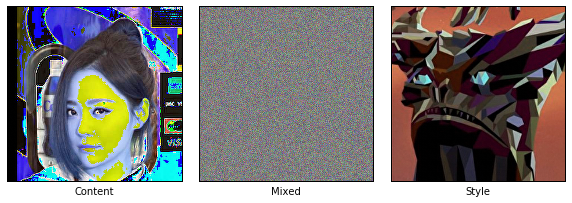

iterations 5 
content_out: 676555.375, style_out: 5.5717586810804634e+17 ,denoise_out: 11332.822265625 ,cost_out: 5.5717586810804634e+17,


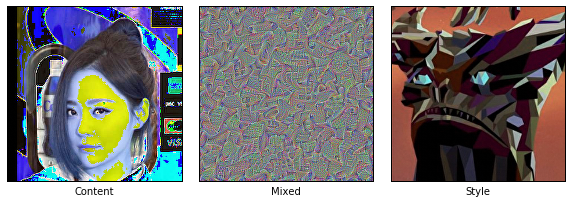

iterations 10 
content_out: 715289.0, style_out: 3.078449076769915e+17 ,denoise_out: 12892.12109375 ,cost_out: 3.078449076769915e+17,


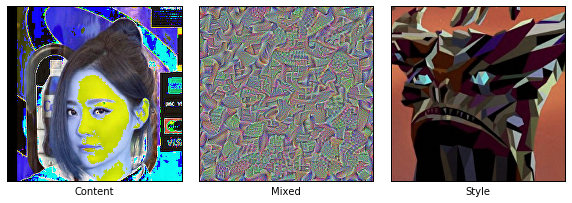

iterations 15 
content_out: 730864.375, style_out: 2.128502984928133e+17 ,denoise_out: 13515.001953125 ,cost_out: 2.128502984928133e+17,


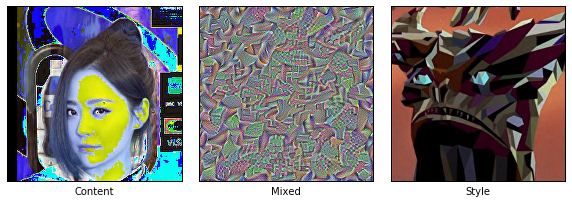

iterations 20 
content_out: 736500.625, style_out: 1.54309585010688e+17 ,denoise_out: 13719.2119140625 ,cost_out: 1.54309585010688e+17,


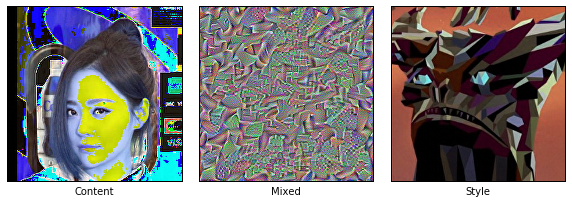

iterations 25 
content_out: 740936.875, style_out: 1.1573399264428032e+17 ,denoise_out: 13851.6376953125 ,cost_out: 1.1573399264428032e+17,


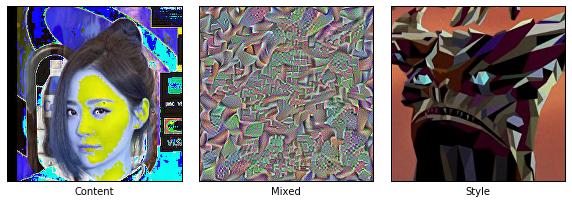

iterations 30 
content_out: 744814.875, style_out: 8.947741445482086e+16 ,denoise_out: 13995.1767578125 ,cost_out: 8.947741445482086e+16,


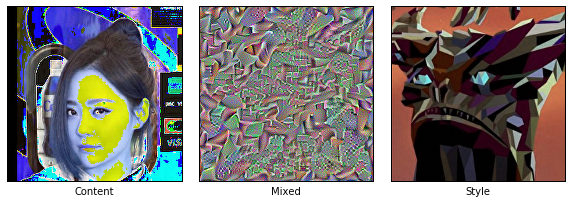

iterations 35 
content_out: 748535.875, style_out: 7.032539077777818e+16 ,denoise_out: 14120.3349609375 ,cost_out: 7.032539077777818e+16,


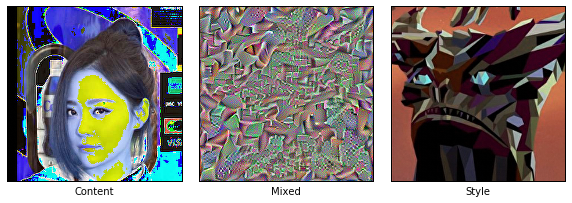

iterations 40 
content_out: 751300.75, style_out: 5.616164519752499e+16 ,denoise_out: 14204.353515625 ,cost_out: 5.616164519752499e+16,


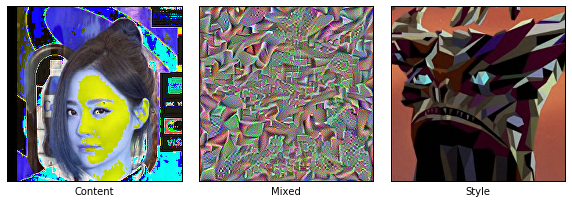

iterations 45 
content_out: 753820.75, style_out: 4.579840450835251e+16 ,denoise_out: 14239.63671875 ,cost_out: 4.579840450835251e+16,


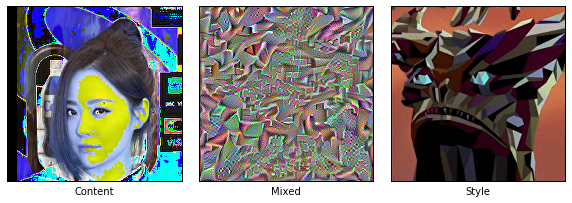

iterations 49 
content_out: 755794.25, style_out: 3.953588692425114e+16 ,denoise_out: 14230.8359375 ,cost_out: 3.953588692425114e+16,


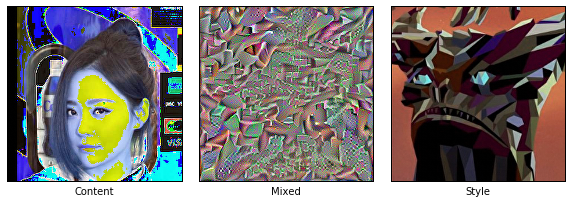

In [14]:
transfer(content,style,content_weight = 1.5,style_weight = 5,denoise_weight = 0.3,epoches = 50)

def style_transfer(content_img,style_img,
                  weight_content=1.5,weight_style=100.0,weight_denoise = 0.3,
                  num_iterations = 120, step_size = 10.0):
    
    mix_img = ((np.random.rand(*content.shape)+128)/224).reshape(1,224,224,3).astype('float32')
    style_values = get_style_info(sess,style_img,layers,style_layer_id)
    content_values = get_content_info(sess,content_img,layers,content_layer_id)
    #mix_img = tf.Variable(((np.random.rand(*content.shape)+128)/224).reshape(1,224,224,3), tf.float32)
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    
    sess.run([adj_content.initializer,adj_style.initializer,adj_denoise.initializer])
    
    for i in range(num_iterations):
        loss_content = content_loss(sess,mix_img,layers,content_layer_id,content_values)
        print(loss_content)
        loss_style = style_loss(sess,mix_img,layers,style_layer_id,style_values)
        loss_denoise = denoise_loss(mix_img)
        print(loss_style)
        update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
        update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
        update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
        loss_combined = weight_content * adj_content * loss_content + weight_style * adj_style * loss_style + weight_denoise * adj_denoise * loss_denoise
        mix_img_tensor = tf.stack(mix_img)
        gradient = tf.gradients(loss_combined,[adj_content,adj_style,adj_denoise])
        #optimizer = tf.train.AdamOptimizer(0.1).minimize(loss_combined)
        #gradient = optimizer.compute_gradients(loss_combined)
        
        #print (gradient)
        #print (mix_img_tensor)
        run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]  
        grad = sess.run(gradient,feed_dict={input_:mix_img})
        print (grad)
        adj_content_val = sess.run(update_adj_content,feed_dict={input_:mix_img})
        adj_style_val = sess.run(update_adj_style,feed_dict = {input_:mix_img})
        adj_denoise_val = sess.run(update_adj_denoise,feed_dict = {input_:mix_img})
        #grad, adj_content_val, adj_style_val, adj_denoise_val= sess.run(run_list, feed_dict={input_:mix_img})
        #grad = np.asarray(grad)[:,0]
        #grad = np.squessze(grad)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        print (step_size_scaled)
        mix_img -= grad * step_size_scaled
        mix_img = np.clip(mix_img, 0.0, 1.0)
        print(". ", end="")
        if (i % 10 == 0) or (i == num_iterations - 1):
            print ()
            print ('Iteration:',i)
            
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            plot_images(content_image=content,
                        style_image=style,
                        mixed_image=mix_img)

style_transfer(content_img,style_img,
                  weight_content=1.5,weight_style=100.0,weight_denoise = 0.3,
                  num_iterations = 120, step_size = 10.0)

sess = tf.Session()
content_layer_ids = [4]
style_layer_ids = [1, 2, 3, 4]
style_tranfer(content,style,content_layer_ids,style_layer_ids,
              weight_content=1.5,weight_style=10.0,weight_denoise = 0.3,
              num_iterations = 120, step_size = 10.0)

sess.close()

sess = tf.InteractiveSession()
mix_value = sess.run(model.conv4_4, feed_dict = {input_:mix_image})

content_value = sess.run(model.conv4_4,feed_dict = {input_:content})

layer_loss = []
for mix,content in zip(mix_value,content_value):
    content_const = tf.constant(content)
    loss = mean_squared_error(mix,content_const)
    layer_loss.append(loss)
total_loss = tf.reduce_mean(layer_loss)

layer_names = [model.conv1_1, model.conv1_2,
               model.conv2_1, model.conv2_2,
               model.conv3_1, model.conv3_2, model.conv3_3,model.conv3_4,
               model.conv4_1, model.conv4_2, model.conv4_3,model.conv4_4,
               model.conv5_1, model.conv5_2, model.conv5_3,model.conv5_4]


gram_mix = []
gram_style = []
for layer in layer_names:
    g_m = sess.run(layer, feed_dict = {input_:mix_image})
    gram_mix.append(gram_matrix(g_m))
    g_s = sess.run(layer, feed_dict = {input_:style})
    gram_style.append(gram_matrix(g_s))

s_layer_loss = []
for value,gram_layer in zip(gram_style,gram_mix):
    #v_c = tf.constant(value)
    style_loss = mean_squared_error(gram_layer,value)
    s_layer_loss.append(style_loss)
total_style_loss = tf.reduce_mean(s_layer_loss)

In [46]:
denoise_loss = tf.reduce_sum(tf.abs(mix_image[:,1,:,:]-mix_image[:,:-1,:,:]))+tf.reduce_sum(tf.abs(mix_image[:,:,1:,:]-mix_image[:,:,:-1,:]))

In [18]:
n = [(95858.312, 1e-10), (1, 1e-10), (132.55542, 1e-10)]
s=np.squeeze(n)

In [33]:
np.squeeze(s).shape

(3, 2)

In [24]:
np.squeeze(np.asarray(n))

array([[  9.58583120e+04,   1.00000000e-10],
       [  1.00000000e+00,   1.00000000e-10],
       [  1.32555420e+02,   1.00000000e-10]])

In [35]:
np.asarray(n)[:,0]

array([  9.58583120e+04,   1.00000000e+00,   1.32555420e+02])